In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
import tqdm
import sys
import os
import gc
import argparse
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pickle
#计算shap值
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']
import math

In [2]:
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('expand_frame_repr', False)  # 即“禁止换行”
# pd.set_option('display.precision', 2) #展示两位小数点
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df_data_交易=pd.read_csv('data/账户交易信息.csv')
df_data_交易.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
df_data_账户=pd.read_csv('data/账户静态信息.csv')
df_data_账户.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
df_label_train=pd.read_csv('data/训练集标签.csv')
df_label_train.columns = ['账户代号','label']
df_label_test=pd.read_csv('data/test_dataset.csv')
df_label_test.columns = ['账户代号']## 读取数据
df_label_all=pd.concat([df_label_train,df_label_test])
df_data_客户列表 = df_data_账户[["账户代号"]]

### 特征提取

#### 抹账处理

In [4]:
df_label_all.head()

,账户代号,label
0,2029FF26D4E2CA79,0.00
1,09F5B90D46FB7CCE,1.00
2,E0C880EB18F4EFE8,1.00
3,ED8FFDCCF93C2F11,1.00
4,8D2F48B0BFC40AB2,1.00


In [5]:
list_交易_金额为负_index = list(df_data_交易[df_data_交易["交易金额"] < 0].index)
list_mz_index = [] ;
list_交易_金额为负_对应的失败交易_index = [] ;
for i in list_交易_金额为负_index :
    S_now = df_data_交易.loc[i] ;
    j = i ;
    while (True) :
        j -= 1 ;
        S_nex = df_data_交易.loc[j] ;
        if (S_now["交易金额"] == -S_nex["交易金额"]) :
            if (S_now["账户代号"] == S_nex["账户代号"]) :
                list_交易_金额为负_对应的失败交易_index.append(j) ;
                list_mz_index.append(i) ;
                break ;
list_交易_抹账需要去除_index = list_交易_金额为负_index + list_交易_金额为负_对应的失败交易_index ;
df_data_交易_去除抹账后=df_data_交易[~df_data_交易.index.isin(list_交易_抹账需要去除_index)]

In [6]:
# 取出抹账的数据
df_data_抹账_账户代号与交易金额 = df_data_交易.loc[list_交易_金额为负_对应的失败交易_index , ['账户代号' , '交易金额']] ;
df_tz_抹账 = df_data_抹账_账户代号与交易金额.groupby('账户代号')['交易金额'].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_tz_抹账.columns = ['账户代号'] + ['抹账_'+ f for f in df_tz_抹账.columns.values if f not in ['账户代号']]

#### 交易渠道

In [7]:
# 获取客户的交易总数
df_tz_交易总数 = df_data_交易_去除抹账后.groupby("账户代号")[["账户代号"]].agg(["count"]).reset_index()
df_tz_交易总数.columns = ["账户代号" , "count"]
df_tz_交易总数 = df_tz_交易总数.sort_values(by=["账户代号"])

In [8]:
df_tz_交易渠道 = df_label_all[["账户代号"]].copy() ;
# 每个客户针对每个交易渠道，去取有多少;
for i in df_data_交易_去除抹账后["交易渠道"].unique() :
    df_now = df_data_交易_去除抹账后[(df_data_交易_去除抹账后["交易渠道"] == i)].groupby("账户代号")["交易金额","交易余额"].agg(["count",'sum','mean','max','min','std']).reset_index() ;
    df_now.columns = ["账户代号"] + ["渠道代号_" + i + "_" + "_".join(f) for f in df_now.columns if f[0] != "账户代号"]
    df_now = df_data_客户列表.merge(df_now , on="账户代号" , how="left").sort_values("账户代号").reset_index(drop=True) ;
    df_now["渠道代号_" + i + "_" + "占总个人交易次数的比例"] = pd.Series(df_now["渠道代号_" + i + "_交易金额_count"].to_numpy() / df_tz_交易总数["count"].to_numpy())
    df_tz_交易渠道 = df_tz_交易渠道.merge(df_now , on="账户代号" , how="left") ;

### 账户代号与对方账户相同的交易

In [9]:
df_data_账户代号与对方账户相同的交易 = df_data_交易[df_data_交易["账户代号"] == df_data_交易["对方账号"]]
df_data_账户代号与对方账户相同的交易_转入交易 = df_data_账户代号与对方账户相同的交易[df_data_账户代号与对方账户相同的交易["借贷标志"] == 1]
df_data_账户代号与对方账户相同的交易_转出交易 = df_data_账户代号与对方账户相同的交易[df_data_账户代号与对方账户相同的交易["借贷标志"] == 0]
df_tz_账户代号与对方账户相同 = df_data_账户代号与对方账户相同的交易.groupby("账户代号")["交易金额"].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_tz_账户代号与对方账户相同_转入交易 = df_data_账户代号与对方账户相同的交易.groupby("账户代号")["交易金额"].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;
df_tz_账户代号与对方账户相同_转出交易 = df_data_账户代号与对方账户相同的交易.groupby("账户代号")["交易金额"].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index() ;

In [10]:
df_tmp = df_tz_账户代号与对方账户相同[["账户代号" , "count"]]
df_tmp = df_tmp.merge(df_tz_交易总数, on="账户代号" , how="left")
df_tmp["账户代号与对方账户相同交易比例"] = df_tmp["count_x"].to_numpy() / df_tmp["count_y"].to_numpy()
df_tz_账户代号与对方账户相同["账户代号与对方账户相同交易比例"] = df_tmp["账户代号与对方账户相同交易比例"]

In [11]:
df_tz_账户代号与对方账户相同.columns = ['账户代号'] + ['账户代号与对方账户相同_'+ f for f in df_tz_账户代号与对方账户相同.columns.values if f not in ['账户代号']]
df_tz_账户代号与对方账户相同_转入交易.columns = ['账户代号'] + ['账户代号与对方账户相同_转入交易_'+ f for f in df_tz_账户代号与对方账户相同_转入交易.columns.values if f not in ['账户代号']]
df_tz_账户代号与对方账户相同_转出交易.columns = ['账户代号'] + ['账户代号与对方账户相同_转出交易_'+ f for f in df_tz_账户代号与对方账户相同_转出交易.columns.values if f not in ['账户代号']]

df_tz_账户代号与对方账户相同 = df_tz_账户代号与对方账户相同.merge(df_tz_账户代号与对方账户相同_转入交易, on="账户代号" , how="left")
df_tz_账户代号与对方账户相同 = df_tz_账户代号与对方账户相同.merge(df_tz_账户代号与对方账户相同_转出交易, on="账户代号" , how="left")

### 对于1-2 4->5  6->7 8->9做时间滑窗

In [12]:
l = [1 , 4 , 6 , 8]
df_tz_可疑账户多交易时间 = df_label_all[["账户代号"]].copy() ;
for i in l :
    begintime = str(i).zfill(2) + ":00:00" ;
    endtime = str(i + 1).zfill(2) + ":00:00" ;
    df_tmp = df_data_交易_去除抹账后[df_data_交易_去除抹账后["交易时间"] <= endtime] ;
    df_tmp = df_tmp[df_tmp["交易时间"] >= begintime] ;
    df_tmp = df_tmp.groupby("账户代号")["交易金额"].agg(['sum','count','mean','max','min','std',np.ptp]).reset_index()
    df_tmp.columns = ['账户代号'] + ['可疑账户多交易时间_' + str(i) + '_'+ f for f in df_tz_账户代号与对方账户相同_转出交易.columns.values if f not in ['账户代号']]
    df_tz_可疑账户多交易时间 = df_tz_可疑账户多交易时间.merge(df_tmp , on="账户代号" , how="left")

In [13]:
df_tz_可疑账户多交易时间.head()

,账户代号,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_sum,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_count,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_mean,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_max,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_min,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_std,可疑账户多交易时间_1_账户代号与对方账户相同_转出交易_ptp,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_sum,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_count,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_mean,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_max,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_min,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_std,可疑账户多交易时间_4_账户代号与对方账户相同_转出交易_ptp,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_sum,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_count,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_mean,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_max,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_min,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_std,可疑账户多交易时间_6_账户代号与对方账户相同_转出交易_ptp,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_sum,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_count,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_mean,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_max,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_min,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_std,可疑账户多交易时间_8_账户代号与对方账户相同_转出交易_ptp
0,2029FF26D4E2CA79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7008.39,1.00,7008.39,7008.39,7008.39,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6979.00,1.00,6979.00,6979.00,6979.00,NaN,0.00
1,09F5B90D46FB7CCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0C880EB18F4EFE8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,1.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.00,4.00,6.75,10.00,2.00,3.95,8.00
3,ED8FFDCCF93C2F11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8D2F48B0BFC40AB2,30.00,3.00,10.00,10.00,10.00,0.00,0.00,39810.50,8.00,4976.31,20000.00,3.50,6545.78,19996.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 特征筛选、训练

In [14]:
df_all = df_label_all.copy() ;
df_all = df_all.merge(df_tz_抹账, on="账户代号" , how="left") 
df_all = df_all.merge(df_tz_交易渠道, on="账户代号" , how="left") 
df_all = df_all.merge(df_tz_账户代号与对方账户相同, on="账户代号" , how="left") 
df_all = df_all.merge(df_tz_可疑账户多交易时间, on="账户代号" , how="left") 

In [15]:
print (df_all.head())

               账户代号  label    抹账_sum  抹账_count   抹账_mean    抹账_max    抹账_min  抹账_std  抹账_ptp  渠道代号_E96ED478_交易金额_count  渠道代号_E96ED478_交易金额_sum  渠道代号_E96ED478_交易金额_mean  渠道代号_E96ED478_交易金额_max  渠道代号_E96ED478_交易金额_min  渠道代号_E96ED478_交易金额_std  渠道代号_E96ED478_交易余额_count  渠道代号_E96ED478_交易余额_sum  渠道代号_E96ED478_交易余额_mean  渠道代号_E96ED478_交易余额_max  渠道代号_E96ED478_交易余额_min  渠道代号_E96ED478_交易余额_std  渠道代号_E96ED478_占总个人交易次数的比例  渠道代号_621461AF_交易金额_count  渠道代号_621461AF_交易金额_sum  渠道代号_621461AF_交易金额_mean  渠道代号_621461AF_交易金额_max  渠道代号_621461AF_交易金额_min  渠道代号_621461AF_交易金额_std  渠道代号_621461AF_交易余额_count  渠道代号_621461AF_交易余额_sum  渠道代号_621461AF_交易余额_mean  渠道代号_621461AF_交易余额_max  渠道代号_621461AF_交易余额_min  渠道代号_621461AF_交易余额_std  渠道代号_621461AF_占总个人交易次数的比例  渠道代号_091D584F_交易金额_count  渠道代号_091D584F_交易金额_sum  渠道代号_091D584F_交易金额_mean  渠道代号_091D584F_交易金额_max  渠道代号_091D584F_交易金额_min  渠道代号_091D584F_交易金额_std  渠道代号_091D584F_交易余额_count  渠道代号_091D584F_交易余额_sum  渠道代号_091D584F_交易余额_mean  渠道代号_091D584F_交易余额_max  渠道代号_091D584F_交易余额

In [16]:
train_label = df_all[:len(df_label_train)] ;
test_label = df_all[len(df_label_train):] ;

In [17]:
def corr_filter(train_data,corr_threshold):
    corr_data=train_data.corr()
    corr_data=corr_data.where(np.triu(np.ones(corr_data.shape),k=1).astype(np.bool))
    high_corr=[column for column in corr_data.columns if any(corr_data[column].abs()>corr_threshold)]
    result=[c for c in train_data.columns if c not in high_corr]
    print("筛选后特征:",len(result))
    return result

In [18]:
cols = [f for f in train_label.columns if f not in ['账户代号','label']]

In [19]:
cols

['抹账_sum',
 '抹账_count',
 '抹账_mean',
 '抹账_max',
 '抹账_min',
 '抹账_std',
 '抹账_ptp',
 '渠道代号_E96ED478_交易金额_count',
 '渠道代号_E96ED478_交易金额_sum',
 '渠道代号_E96ED478_交易金额_mean',
 '渠道代号_E96ED478_交易金额_max',
 '渠道代号_E96ED478_交易金额_min',
 '渠道代号_E96ED478_交易金额_std',
 '渠道代号_E96ED478_交易余额_count',
 '渠道代号_E96ED478_交易余额_sum',
 '渠道代号_E96ED478_交易余额_mean',
 '渠道代号_E96ED478_交易余额_max',
 '渠道代号_E96ED478_交易余额_min',
 '渠道代号_E96ED478_交易余额_std',
 '渠道代号_E96ED478_占总个人交易次数的比例',
 '渠道代号_621461AF_交易金额_count',
 '渠道代号_621461AF_交易金额_sum',
 '渠道代号_621461AF_交易金额_mean',
 '渠道代号_621461AF_交易金额_max',
 '渠道代号_621461AF_交易金额_min',
 '渠道代号_621461AF_交易金额_std',
 '渠道代号_621461AF_交易余额_count',
 '渠道代号_621461AF_交易余额_sum',
 '渠道代号_621461AF_交易余额_mean',
 '渠道代号_621461AF_交易余额_max',
 '渠道代号_621461AF_交易余额_min',
 '渠道代号_621461AF_交易余额_std',
 '渠道代号_621461AF_占总个人交易次数的比例',
 '渠道代号_091D584F_交易金额_count',
 '渠道代号_091D584F_交易金额_sum',
 '渠道代号_091D584F_交易金额_mean',
 '渠道代号_091D584F_交易金额_max',
 '渠道代号_091D584F_交易金额_min',
 '渠道代号_091D584F_交易金额_std',
 '渠道代号_091D584F_交易余额_count',
 '渠道代号

In [20]:
# corr_filter(train_label[cols],0.99)

In [20]:
def 对抗验证获取数据(df_train,df_test,threshold):
    # 定义新的Y
    
    
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1
    #print(df_train.columns)
    #print(df_test.columns)
    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])
    #print(df_adv.columns)
    #catecol_list_index=[list(df_train.columns).index(c) for c in df_train.select_dtypes(include=['category']).columns]
    # 通过抗验证中的模型，得到各个样本属于测试集的概率


    
    model_adv =  lgb.LGBMClassifier()
    model_adv.fit(df_adv.drop(['label','Is_Test'], axis=1), df_adv.loc[:, 'Is_Test'])
    preds_adv = model_adv.predict_proba(df_adv.drop(['label','Is_Test'], axis=1))[:, 1]
    
    df_train_copy = df_train.copy()
    df_train_copy['is_test_prob'] = preds_adv[:len(df_train)]

    # 根据概率排序
    df_train_copy = df_train_copy.sort_values('is_test_prob').reset_index(drop=True)

    # 将概率最大的20%作为验证集
    df_validation_2 = df_train_copy.iloc[int(threshold * len(df_train)):, ]
    df_train_2 = df_train_copy.iloc[:int(threshold * len(df_train)), ]
    return df_validation_2.drop(['is_test_prob','Is_Test'], axis=1)#,df_train_copy.drop(['Is_Test'],axis=1)
def 对抗验证获得新的列(df_train,df_test,threshold):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])

    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':32,'max_depth':10,'n_estimators':200,'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.08}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])
    #preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})

    im=im.sort_values(by='importance',ascending=False)
        
    new_cat=im.reset_index().loc[round(len(im)*threshold):,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return new_cat

In [21]:
# new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.6)
# cols=list(new_cat)
# col_valid=cols.copy()
# col_valid.append('label')
# valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.8)

In [23]:
new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.2)
cols=list(new_cat)
col_valid=cols.copy()
col_valid.append('label')
valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.2)

对抗验证后的特征数量为: 264


In [22]:
cols

['抹账_sum',
 '抹账_count',
 '抹账_mean',
 '抹账_max',
 '抹账_min',
 '抹账_std',
 '抹账_ptp',
 '渠道代号_E96ED478_交易金额_count',
 '渠道代号_E96ED478_交易金额_sum',
 '渠道代号_E96ED478_交易金额_mean',
 '渠道代号_E96ED478_交易金额_max',
 '渠道代号_E96ED478_交易金额_min',
 '渠道代号_E96ED478_交易金额_std',
 '渠道代号_E96ED478_交易余额_count',
 '渠道代号_E96ED478_交易余额_sum',
 '渠道代号_E96ED478_交易余额_mean',
 '渠道代号_E96ED478_交易余额_max',
 '渠道代号_E96ED478_交易余额_min',
 '渠道代号_E96ED478_交易余额_std',
 '渠道代号_E96ED478_占总个人交易次数的比例',
 '渠道代号_621461AF_交易金额_count',
 '渠道代号_621461AF_交易金额_sum',
 '渠道代号_621461AF_交易金额_mean',
 '渠道代号_621461AF_交易金额_max',
 '渠道代号_621461AF_交易金额_min',
 '渠道代号_621461AF_交易金额_std',
 '渠道代号_621461AF_交易余额_count',
 '渠道代号_621461AF_交易余额_sum',
 '渠道代号_621461AF_交易余额_mean',
 '渠道代号_621461AF_交易余额_max',
 '渠道代号_621461AF_交易余额_min',
 '渠道代号_621461AF_交易余额_std',
 '渠道代号_621461AF_占总个人交易次数的比例',
 '渠道代号_091D584F_交易金额_count',
 '渠道代号_091D584F_交易金额_sum',
 '渠道代号_091D584F_交易金额_mean',
 '渠道代号_091D584F_交易金额_max',
 '渠道代号_091D584F_交易金额_min',
 '渠道代号_091D584F_交易金额_std',
 '渠道代号_091D584F_交易余额_count',
 '渠道代号

In [23]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2023
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }

            model = clf.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 8
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            
            model = clf(
                        n_estimators=10000,
                        random_seed=1024,
                        eval_metric='AUC',
                        learning_rate=0.05,
                        max_depth=5,
                        early_stopping_rounds=200,
                        metric_period=500,
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
       
    return oof, predict

In [25]:
# xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols])
xgb_oof, xgb_pred = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb')
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb',valid[cols])


************************************ 1 ************************************
[0]	train-auc:0.87593	eval-auc:0.86907
[546]	train-auc:0.99980	eval-auc:0.93546
[0.937037037037037]
************************************ 2 ************************************
[0]	train-auc:0.89060	eval-auc:0.83074
[653]	train-auc:0.99960	eval-auc:0.94781
[0.937037037037037, 0.9514316781442551]
************************************ 3 ************************************
[0]	train-auc:0.89994	eval-auc:0.77607
[957]	train-auc:0.99964	eval-auc:0.94054
[0.937037037037037, 0.9514316781442551, 0.9408353808353809]
************************************ 4 ************************************
[0]	train-auc:0.86381	eval-auc:0.82894
[637]	train-auc:0.99965	eval-auc:0.95588
[0.937037037037037, 0.9514316781442551, 0.9408353808353809, 0.9582997040624159]
************************************ 5 ************************************
[0]	train-auc:0.89178	eval-auc:0.80875
[1000]	train-auc:0.99975	eval-auc:0.92509
[1141]	train-auc:0.

In [26]:
oof = xgb_oof
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.6,0.01):
    preds = (oof.reshape((-1))>threshold).astype('int')
    m = f1_score(train_label['label'].values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
    print(f'{threshold:.02f}, {m}')
print(f'{best_threshold:.02f}, {best_score}')
# 0.47, 0.9150898680694286 # 0.86579572447
# 0.43, 0.9217716422203048 # 0.86697783
# 0.41, 0.9198568108353592 # 0.87674418605
# 0.40, 0.9231997065541027 # 0.87819025522
# 0.42, 0.913822737200522  # 0.87639132982 
# 0.40, 0.9148403872302214 # 0.88313184

0.40, 0.8768100586282406
0.41, 0.878789137467656
0.42, 0.8794998105342933
0.43, 0.8792155849877885
0.44, 0.8822156045265038
0.45, 0.8780557952257694
0.46, 0.8767563894229339
0.47, 0.8748435544430538
0.48, 0.8745348301379731
0.49, 0.8715748426791823
0.50, 0.8709278721481906
0.51, 0.8695896086807109
0.52, 0.8692578222004537
0.53, 0.8662182280624038
0.54, 0.8672309351921003
0.55, 0.8576383315770741
0.56, 0.8572615202847573
0.57, 0.8568815614742802
0.58, 0.8550981307658868
0.59, 0.8500571428571428
0.44, 0.8822156045265038


In [27]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>best_threshold).astype('int')


KeyError: "None of [Index(['zhdh', 'black_flag'], dtype='object')] are in the [columns]"

In [29]:
test_label[['账户代号','label']].to_csv('submission.csv', index=False)

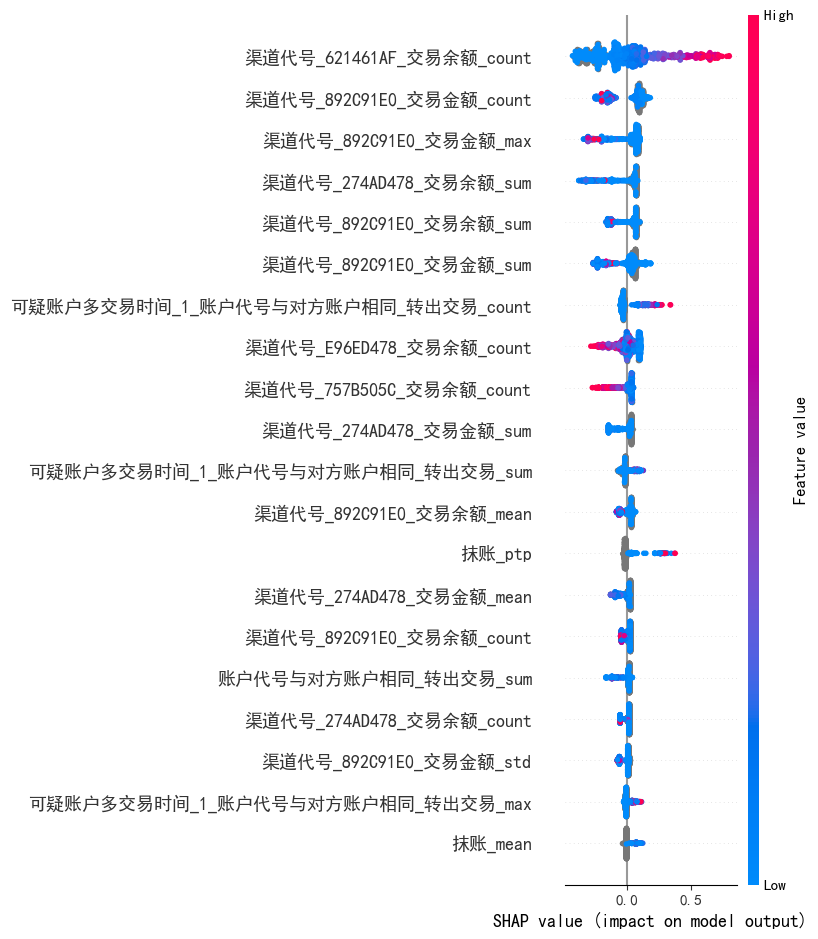

In [27]:
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(train_label[cols])
#shap.summary_plot(shap_values[1], train_label[cols])
shap.summary_plot(shap_values, train_label[cols])

In [28]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>0.42).astype('int')
result=test_label[['账户代号','label']]
result.columns=['zhdh','black_flag']
result.to_csv('submission20230305.csv', index=False)
result['black_flag'].value_counts()

0    3668
1    1132
Name: black_flag, dtype: int64